> # NEURAL NETWORKS MINI-PROJECT - CIFAR-10 CLASSIFICATION

 # Image Classification on CIFAR10 Data


# Libraries
> *   Import necessary PyTorch libraries and submodules for building and training neural networks.
> *  Import other essential libraries such as NumPy for numerical operations and Matplotlib for plotting.
> * Import the random library and set a random seed to ensure reproducibility of results across different runs.
> * Check if a GPU is available for computation and assign it to a variable called compute_device. 
> * If a GPU is available, set the random seed for it and disable non-deterministic cuDNN algorithms to ensure reproducibility.



In [ ]:
# Import required PyTorch libraries and submodules
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import OneCycleLR
from torch import Tensor

# Import other essential libraries
import numpy as np
import matplotlib.pyplot as plt
import os

# Import random library and set random seed for reproducibility
import random

rand_seed = 1002
torch.manual_seed(rand_seed)
random.seed(rand_seed)
np.random.seed(rand_seed)

# Determine if GPU is accessible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Utilizing device:", device)

# Set the random seed for GPU and disable non-deterministic cuDNN algorithms
if device.type == 'cuda':
    torch.cuda.manual_seed_all(rand_seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Utilizing device: cuda:0


>  ## Set hyperparameters and constants

In [ ]:
batch_size = 128 # Number of samples per gradient update
learning_rate = 0.001 # Initial learning rate for optimization
num_epochs = 60 # Number of times the entire dataset is iterated
num_blocks = 3 # Number of residual blocks in the network
num_conv_layer = 3 # Number of convolutional layers per residual block

>  ## CIFAR-10 dataset specific constants

In [ ]:
num_classes = 10 # Number of distinct classes ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
input_channels = 3 # Number of color channels in input images (RGB)
input_size = 32 # Height and width of input images in pixels

# Transformations
>   Define necessary transformations for data augmentation and normalization

In [ ]:
transform_train = transforms.Compose([
transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
transforms.RandomCrop(input_size, padding=4), # Randomly crop the image with padding
transforms.ToTensor(), # Convert the image to a PyTorch tensor
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the image with mean and std
])


>   Define necessary transformations for normalization only (for testing)

In [ ]:
transform_test = transforms.Compose([
transforms.ToTensor(), # Convert the image to a PyTorch tensor
transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalize the image with mean and std
])

  # Download the CIFAR-10 dataset and apply transformations

In [ ]:
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train) # Load the training data with specified transformations
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test) # Load the testing data with specified transformations

Files already downloaded and verified
Files already downloaded and verified


# Create data loaders for train and test sets with specified batch size and worker settings

In [ ]:
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2) # Create a train data loader with shuffling and using 2 workers
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2) # Create a test data loader without shuffling and using 2 workers

  # Definition of BasicBlock class

>   Constructor method of BasicBlock class that extends the nn.Module class. in_channels and out_channels are integers, and num_conv_layer is the number of convolutional layers.
>   The nn.AdaptiveAvgPool2d module calculates the average of the input tensor and reduces the spatial dimensions to 1.

>  A linear transformation is performed on the input tensor using nn.Linear. The number of input features is equal to the number of input channels, and the number of output features is equal to num_conv_layer. The nn.LeakyReLU activation function is applied in-place.

>   nn.ModuleList is used to define a list of convolutional layers. Each layer contains a convolutional layer, a batch normalization layer, a LeakyReLU activation function, and a max-pooling layer. There are num_conv_layer convolutional layers in the block.

>   The forward method of the BasicBlock class receives an input tensor x. The input tensor is passed through the nn.AdaptiveAvgPool2d module to obtain the spatial average.

In [ ]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, num_conv_layer):
        super(BasicBlock, self).__init__()
        self.spatial_avg_pool = nn.AdaptiveAvgPool2d(1) #The nn.AdaptiveAvgPool2d module calculates the average of the input tensor and reduces the spatial dimensions to 1.
        self.linear = nn.Linear(in_channels, num_conv_layer) # linear transformation
        self.activation = nn.LeakyReLU(inplace=True) #LeakyReLU activation function
        self.convs = nn.ModuleList([ # List of Convolution Layer
            nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        
            for _ in range(num_conv_layer)
        ])

 # Add a new convolutional layer with batch normalization and activation
        self.convs.append(
            nn.Sequential(
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        )
    def forward(self, x):
        spatial_avg = self.spatial_avg_pool(x).view(x.size(0), -1) # Spatial average is obtained
        a = self.activation(self.linear(spatial_avg))

        def apply_conv(conv: nn.Sequential, x: Tensor) -> Tensor:
            return conv(x)
        #The torch.jit.fork function is used to create a separate computation graph for each convolutional layer, allowing for parallel computation.
        #The sum of the element-wise multiplication of a slice of the tensor a and the corresponding output tensor from apply_conv is taken.
        #This process is repeated for each convolutional layer in self.convs.    
        outputs = [torch.jit.fork(apply_conv, self.convs[i], x) for i in range(a.size(1))]
        O = sum(a[:, i].view(-1, 1, 1, 1) * torch.jit.wait(outputs[i]) for i in range(a.size(1)))

        return O



## Class Backbone
>   This class defines a neural network module for backbone architecture.
>   It takes four parameters:

>  * num_blocks: number of blocks in the backbone architecture
>  * in_channels: number of input channels
>  * out_channels: number of output channels
>  * num_conv_layer: number of convolutional layers in each block


# Method init
>  * Initializes the Backbone class with the given parameters.
>  * Defines a list of ModuleList containing BasicBlock instances for each block in the backbone architecture.
 # Method forward
>  * Takes an input tensor x and passes it through each block sequentially.
>  * Returns the output of the last block.




In [ ]:
class Backbone(nn.Module):
    def __init__(self, num_blocks, in_channels, out_channels, num_conv_layer):
        super(Backbone, self).__init__()

        self.blocks = nn.ModuleList([
            BasicBlock(in_channels if i == 0 else out_channels, out_channels, num_conv_layer) #a list of ModuleList containing BasicBlock instances for each block in the backbone architecture
            for i in range(num_blocks)
        ])

    def forward(self, x):
        # Pass the input tensor through each block sequentially
        for block in self.blocks:
            x = block(x)

        # Return the output of the last block (ON)
        return x

# Class Classifier
>  This class defines a neural network module for classification.
> * It takes three parameters:
> * in_features: number of input features
> * hidden_size: number of hidden units in the MLP layers
> * num_classes: number of output classes
# Method init
> * Initializes the Classifier class with the given parameters.
> * Defines an AdaptiveAvgPool2d layer to compute the mean feature.
> * Defines an MLP with three linear layers:
> * First linear layer with input size in_features and output size hidden_size
> * Second linear layer with input and output size hidden_size
> * Final linear layer with input size hidden_size and output size num_classes
> * Adds batch normalization and dropout layers after each linear layer except the final one.
# Method forward
> * Takes an input tensor x.
> * Computes the mean feature f by applying the spatial average pooling layer on x and flattening the output.
> * Passes f through the MLP layers.
> *  Returns the class logits.

In [ ]:
class Classifier(nn.Module):
    def __init__(self, in_features, hidden_size, num_classes):
        super(Classifier, self).__init__()

        self.spatial_avg_pool = nn.AdaptiveAvgPool2d(1)  #Defines an AdaptiveAvgPool2d layer to compute the mean feature
        
        # Updated MLP with additional layers and batch normalization
        self.mlp = nn.Sequential(
            # First linear layer
            nn.Linear(in_features, hidden_size),
            nn.BatchNorm1d(hidden_size),  # Added batch normalization
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),

            # Second linear layer (added for increased depth)
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),  # Added batch normalization
            nn.LeakyReLU(inplace=True),
            nn.Dropout(p=0.5),

            # Final linear layer for classification
            nn.Linear(hidden_size, num_classes)
        )

    def forward(self, x):
        # Compute the mean feature f as SpatialAveragePool(ON)
        f = self.spatial_avg_pool(x).view(x.size(0), -1)

        # Pass f through the classifier layers (MLP)
        logits = self.mlp(f)

        # Return the class logits
        return logits


# Class Model
> * This class extends the nn.Module class and takes six parameters:
> * num_blocks: number of blocks in the backbone architecture
> * input_channels: number of input channels
> * backbone_out_channels: number of output channels in the backbone architecture
> * num_conv_layer: number of convolutional layers in each block of the backbone architecture
> * hidden_size: size of the hidden layer in the classifier
> * num_classes: number of classes in the classification task

# Method init
> * Initializes the Model class with the given parameters.
> * Creates an instance of the Backbone module and an instance of the Classifier module.
 # Method forward
> * Takes an input tensor x and passes it through the Backbone module to get the feature representation.
> * Passes the output of the Backbone module to the Classifier module to get the logits.
> * Returns the logits.

In [ ]:
class Model(nn.Module):
    def __init__(self, num_blocks, input_channels, backbone_out_channels, num_conv_layer, hidden_size, num_classes):
        super(Model, self).__init__()

        self.backbone = Backbone(num_blocks, input_channels, backbone_out_channels, num_conv_layer)
        self.classifier = Classifier(backbone_out_channels, hidden_size, num_classes)

    def forward(self, x):
        x = self.backbone(x) # Takes an input tensor x and passes it through the Backbone module to get the feature representation.
        logits = self.classifier(x)
        return logits

In [ ]:
# Initialize the model with desired parameters
model = Model(num_blocks, input_channels, backbone_out_channels=1024, num_conv_layer=num_conv_layer, hidden_size=512, num_classes=num_classes).to(device)

# Loss Function

> * The Cross Entropy Loss measures the difference between the predicted probability distribution and the actual probability distribution of the target class. It does this by computing the negative log-likelihood of the predicted class. The output of the loss function is a scalar value which represents the average loss over all samples in the mini-batch.

> * The loss function is defined as "Lossfunc" and can be used during training to calculate the loss of the model's predictions and optimize the model's parameters to minimize this loss.

In [ ]:
# Define the loss function
Lossfunc = nn.CrossEntropyLoss()


# Optimizer - Ranger


> * model.parameters() specifies the parameters of the model to be optimized.
> * lr=learning_rate sets the learning rate of the optimizer to the value of the learning_rate variable.
> * weight_decay=1e-2 sets the L2 regularization strength for the optimizer. A weight decay of 1e-2 means that the weights will be decayed by 0.01 at each update. This helps prevent overfitting of the model by penalizing large weights.
> * The optimizer variable holds the instance of the optimizer with the specified settings.

In [ ]:
!git clone https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer

fatal: destination path 'Ranger-Deep-Learning-Optimizer' already exists and is not an empty directory.


In [ ]:
#setting path in colab
 
import os

#set the working directory 

root_dir = "/content/"

#choose the project folder
project_folder = "Ranger-Deep-Learning-Optimizer"

#define a function to create and set the working directory
def create_and_set_working_directory(project_folder):
  #check if the project folder exists. if not, make one.
  if os.path.isdir(root_dir + project_folder) == False:
    os.mkdir(root_dir + project_folder)
    print(root_dir + project_folder + 'did not existed and was created.')
  
  #change the OS path to project folder as working directory
os.chdir(root_dir + project_folder)

  #create a test file in the working directory and see if it shows up at the right place
!touch 'new_file_test.txt'
print('working directory' + root_dir + project_folder + \
        "empty text file created. You can also run !pwd command to confirm working directory.")

create_and_set_working_directory(project_folder)
#to set working directory

working directory/content/Ranger-Deep-Learning-Optimizerempty text file created. You can also run !pwd command to confirm working directory.


In [ ]:

!pip install -e . 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/Ranger-Deep-Learning-Optimizer
  Preparing metadata (setup.py) ... done
  Attempting uninstall: ranger
    Found existing installation: ranger 0.1.dev0
    Can't uninstall 'ranger'. No files were found to uninstall.
  Running setup.py develop for ranger


In [ ]:

from ranger import Ranger  # this is from ranger.py
from ranger import RangerVA  # this is from ranger913A.py
from ranger import RangerQH  # this is from rangerqh.py


# Define the optimizer
optimizer = Ranger(model.parameters(), lr=learning_rate, weight_decay=1e-2)


Ranger optimizer loaded. 
Gradient Centralization usage = True
GC applied to both conv and fc layers


# Scheduler





One Cycle LR Scheduler offers Faster Convergence, Improved generalization, Automatic Learning rate annealing, reduced need for extensive hyperparameter tuning, Robustness to weight initialization and batch size, Momentum Scheduling.


In [ ]:
# After defining the optimizer

# One-Cycle Learning Rate Scheduler

steps_per_epoch = len(train_loader)
scheduler = OneCycleLR(optimizer, max_lr=0.1, total_steps=num_epochs*steps_per_epoch, anneal_strategy='linear')

> * train_Loss: to store the training losses for each epoch
> * train_accuracy: to store the training accuracies for each epoch
> * test_Loss: to store the testing losses for each epoch
> * test_accuracy: to store the testing accuracies for each epoch


> These lists can be used to track the performance of the model during training and testing and can help in analyzing and improving the model's performance. The values for these lists are usually updated after each epoch of the training and testing phases of the model.

In [ ]:
# Add lists to store losses and accuracies for each epoch
train_Loss = []
train_accuracy = []
test_Loss = []
test_accuracy = []




# Training the model
> *  The model is trained for a specified number of epochs (num_epochs).
> * For each epoch, the training loss (train_loss), number of correct predictions (correct), and total number of examples (total) are initialized to 0.
> * The model is set to training mode using the train() method.
> * For each batch of examples (inputs, labels) in the training data (train_loader), the inputs and labels are moved to the device (CPU or GPU) using the to() method.
> * The optimizer's gradients are set to zero using the zero_grad() method.
> * The inputs are passed through the model using the forward() method to get the outputs.
> * The loss between the outputs and labels is calculated using the specified loss function (Lossfunc).
> * The gradients of the loss are calculated using backward() method.
> * The optimizer is updated using the step() method.
> * The training loss is updated with the item() method to obtain the scalar value of the loss.
> * The number of correct predictions and total number of examples are calculated and accumulated.
> * The learning rate is updated using the scheduler's step() method.

# Evaluating the model
> * The model is set to evaluation mode using the eval() method.
> * The inputs are passed through the model using the forward() method to get the outputs.
> * The loss between the outputs and labels is calculated using the specified loss function (Lossfunc).
> * The test loss is updated with the item() method to obtain the scalar value of the loss.
> * The number of correct predictions and total number of examples are calculated and accumulated.


In [ ]:
# Add lists to store losses and accuracies for each epoch
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Train the model
for epoch in range(num_epochs):
    train_loss = 0.0
    correct = 0
    total = 0

    model.train()  # Set the model to training mode

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate the loss
        loss = Lossfunc(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update training loss
        train_loss += loss.item()

        # Compute training accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    # Update the learning rate using the scheduler
    scheduler.step()

    # Evaluate the model
    model.eval()  # Set the model to evaluation mode

    test_loss = 0.0
    test_correct = 0
    test_total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)

            # Calculate the loss
            loss = Lossfunc(outputs, labels)

            # Update test loss
            test_loss += loss.item()

            # Compute test accuracy
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    # Compute and report the average test loss and test accuracy
    avg_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)
    # Print training progress
    print(f'Epoch [{epoch+1}/{num_epochs}],Train Accuracy: {100*correct/total:.2f}%,Test Accuracy: {test_accuracy:.2f}%, Train Loss: {train_loss/len(train_loader):.4f},Test Loss: {avg_test_loss:.4f}')
    


Epoch [1/60],Train Accuracy: 33.74%,Test Accuracy: 51.17%, Train Loss: 1.7770,Test Loss: 1.3875
Epoch [2/60],Train Accuracy: 54.34%,Test Accuracy: 58.74%, Train Loss: 1.2695,Test Loss: 1.1412
Epoch [3/60],Train Accuracy: 62.59%,Test Accuracy: 65.54%, Train Loss: 1.0594,Test Loss: 0.9952
Epoch [4/60],Train Accuracy: 67.63%,Test Accuracy: 68.28%, Train Loss: 0.9248,Test Loss: 0.8947
Epoch [5/60],Train Accuracy: 70.90%,Test Accuracy: 70.03%, Train Loss: 0.8350,Test Loss: 0.8316
Epoch [6/60],Train Accuracy: 73.87%,Test Accuracy: 76.34%, Train Loss: 0.7535,Test Loss: 0.6710
Epoch [7/60],Train Accuracy: 75.73%,Test Accuracy: 78.47%, Train Loss: 0.7001,Test Loss: 0.6189
Epoch [8/60],Train Accuracy: 77.62%,Test Accuracy: 78.12%, Train Loss: 0.6496,Test Loss: 0.6330
Epoch [9/60],Train Accuracy: 79.13%,Test Accuracy: 78.40%, Train Loss: 0.6033,Test Loss: 0.6331
Epoch [10/60],Train Accuracy: 80.60%,Test Accuracy: 78.79%, Train Loss: 0.5657,Test Loss: 0.6131
Epoch [11/60],Train Accuracy: 81.76%,Te

# Computing and reporting average test loss and test accuracy
> * The average test loss is computed by dividing the test loss by the length of the test data loader.
> * The test accuracy is computed by dividing the number of correct predictions by the total number of examples and multiplying by 100.
> * The training and test loss and accuracy values are appended to lists for further analysis.
> * The training progress is printed for each epoch.

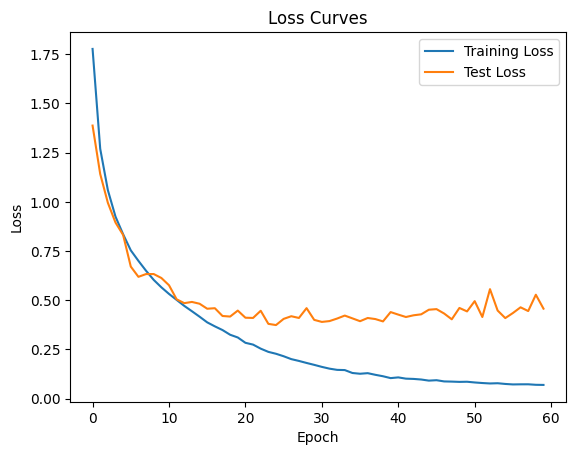

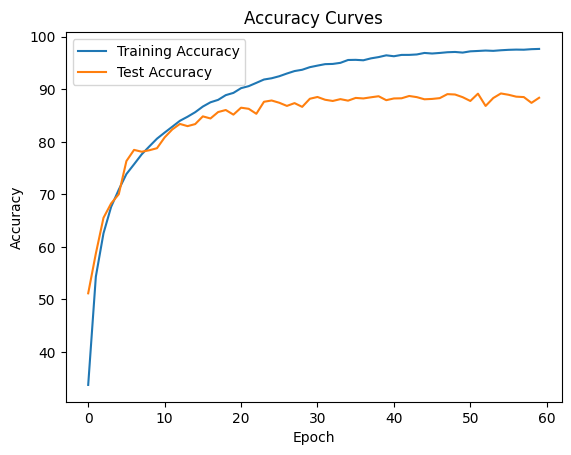

In [ ]:
# Plot the loss curves
plt.figure()
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curves")
plt.show()

# Plot the accuracy curves
plt.figure()
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(test_accuracies, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curves")
plt.show()

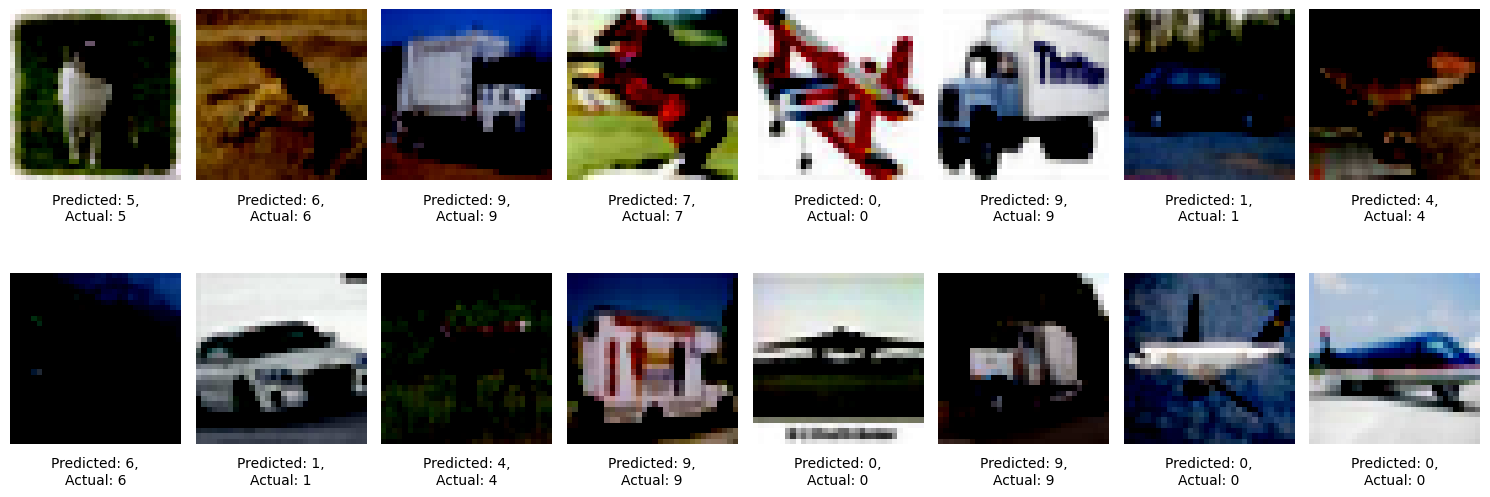

In [ ]:
# Validation set visualization
model.eval()  # Set the model to evaluation mode

# Select a random subset of images from the validation set
indices = np.random.choice(len(test_set), size=16, replace=False)
test_images = [test_set[i][0] for i in indices]
val_labels = [test_set[i][1] for i in indices]

# Predict the labels for the selected images
with torch.no_grad():
    test_images = torch.stack(test_images).to(device)
    test_outputs = model(test_images)
    test_predicted_labels = test_outputs.argmax(dim=1).cpu().numpy()

# Display the selected images with predicted and actual labels
plt.figure(figsize=(15, 6))
for i in range(len(indices)):
    plt.subplot(2, 8, i + 1)
    plt.imshow(test_images[i].cpu().numpy().transpose(1, 2, 0))
    plt.axis("off")
    
     
    title = f"Predicted: {test_predicted_labels[i]},\nActual: {val_labels[i]}"
    plt.title(title, y=-0.3, fontsize=10, pad=8)

plt.tight_layout()
plt.show()


# Conclusion:

Implementation of Custom architecture of this model for image classification on CIFAR-10 Dataset has given a training accuracy of 97.69 % and test accuracy of 88.39 % on 60th Epoch. 

The results show that model's performance on the CIFAR-10 dataset has improved over the course of 60 epochs. The highest test accuracy (89.21%) is achieved in epoch 55, with a corresponding test loss of 0.4093.

The model's training accuracy increases from 33.74% in the first epoch to 97.69% in the final epoch. Meanwhile, the test accuracy increases from 51.17% to 88.39%. This shows that the model is learning and generalizing well to the test set, though there is a gap between training and test accuracy, which may indicate overfitting.


# Reference:

# Data Augmentation:
> *https://towardsdatascience.com/data-augmentation-for-deep-learning-4fe21d1a4eb9

# Convolutions:
> * https://towardsdatascience.com/a-comprehensive-introduction-to-different-types-of-convolutions-in-deep-learning-669281e58215

## Scheduler - One Cycle Learning rate Scheduler
> * https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html

## Optimizer - Ranger

> * citation:
@misc{Ranger,
  author = {Wright, Less},
  title = {Ranger - a synergistic optimizer.},
  year = {2019},
  publisher = {GitHub},
  journal = {GitHub repository},
  howpublished = {\url{https://github.com/lessw2020/Ranger-Deep-Learning-Optimizer}}
}
> * https://medium.com/@lessw/new-deep-learning-optimizer-ranger-synergistic-combination-of-radam-lookahead-for-the-best-of-2dc83f79a48d